In [1]:
%run ../MLHCExperiment-Common-Val17Test18.ipynb

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
all_visits = read_data()
all_visits = all_visits.where(all_visits["AdjCount"] > 0).dropna()

In [3]:
epochs = 1000
patience = 10
trials = 5

In [4]:
def run_one_step_ahead_nn(name, features, label, epochs, patience, trials):
    print(name)
    X = all_visits[features]
    y = all_visits[label]

    mses = list()
    early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error',
                                               patience=patience, restore_best_weights=True)
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_for_baseline_and_nn(X, y)

    OSH_DATES = X.loc[VAL_END:TEST_END].index
    
    for j in range(trials):
        print("\nTrial %d" % (j+1))
        start = time.time()
        predictions = list()

        mod = build_nn_model_generic(X_train, 64, 64)
        history = mod.fit(X_train, y_train.values, epochs=epochs, shuffle=False,
                            validation_data=[X_val, y_val.values], verbose=0,
                            callbacks=[PrintDot(), early_stop])
        
        # serialize weights to HDF5
        model_name = name + "-Trial" + str(j) + "-" + str(time.time()) + ".h5"
        mod.save_weights(model_name)
        
        
        optimizer = tf.train.AdamOptimizer(1e-3)
        mod.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

        # fit time series model
        for i in range(len(OSH_DATES) - 1):
            start2 = time.time()
            prev_date = OSH_DATES[i]
            next_date = OSH_DATES[i + 1]

            if i == 0:
                mod.fit(X_val, y_val.values, epochs=1, shuffle=False, verbose=0)
            if i > 0:
                mod.fit(X_test.loc[prev_date].values.reshape(1, -1),
                        pd.Series(y_test.loc[prev_date]).values,
                        epochs=1, shuffle=False, verbose=0)

            # keras makes it really hard to predict one day, so predict the whole future and take
            # the first result
            y_pred = mod.predict(X_test.loc[next_date:], batch_size=1)
            predictions.extend(y_pred[0])
            end2 = time.time()
            if i % 14 == 0:
                print("14d ending with %s done; last one took %.2f s" % (str(next_date), end2-start2))

        mses.append(mean_squared_error(predictions, y_test))
        end = time.time()
        print("Trial completed in %.2f s" % (end - start))
        print("Average MSE so far: %.3f (%.3f)" % (np.mean(mses), np.std(mses)))
    
    print_mse_metrics(mses)
    y_pred = np.array(predictions).flatten()
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.set(title=name, xlabel='Date', ylabel='Sick Visits Per FTE')
    all_visits.loc[TEST_START:, label].plot(ax=ax, color='gray', style='.', label='actual sick visits/fte')
    plt.scatter(all_visits.loc[TEST_START:].index, y_pred, color='r',label='predicted sick visits/fte')
    plt.legend()
    
    print(y_pred)
    return mses, y_pred

OSA-NN-1DayLag-AllVisits

Trial 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
......................................................14d ending with 2018-01-01 00:00:00 done; last one took 1.35 s
14d ending with 2018-01-15 00:00:00 done; last one took 0.11 s
14d ending with 2018-01-29 00:00:00 done; last one took 0.11 s
14d ending with 2018-02-12 00:00:00 done; last one took 0.13 s
14d ending with 2018-02-26 00:00:00 done; last one took 0.13 s
14d ending with 2018-03-13 00:00:00 done; last one took 0.11 s
14d ending with 2018-03-27 00:00:00 done; last one took 0.09 s
14d ending with 2018-04-10 00:00:00 done; last one took 0.13 s
14d ending with 2018-04-24 00:00:00 d

[ 2.9541903  10.714353    9.190865    1.4582508   9.659932    3.5601003
  1.8452961   9.567555    7.1810093   6.931107    6.53096     6.137193
  2.3230913   0.9949941   8.594792    6.743919    7.073417    6.0245094
  7.77923     3.5064394   1.6551523   9.532597    8.318398    8.608482
  8.931       9.778517    5.9552655   2.5774355  10.530104   11.255242
 10.116228    9.522776   10.104066    5.6731286   2.4729142   9.513113
 10.446955    9.338414    8.338311    9.749602    6.240388    2.3789203
 11.160908   11.32503     9.696851    9.0767765   9.718901    5.1580486
  1.7705021  10.859536    8.510515    8.800947    8.667189    8.851211
  4.2893867   2.1286936  11.134907    8.605196    8.0116825   7.8606524
  7.5109863   3.2108042   1.8376294  10.124594    7.468751    6.8252444
  6.776874    2.6754801   1.3236767  10.492865    5.9332237   6.2862735
  6.475308    6.985023    2.5241234   1.2368755  10.197264    6.371182
  0.7137816   4.723571    6.454444    2.461369    1.1197857   9.322058

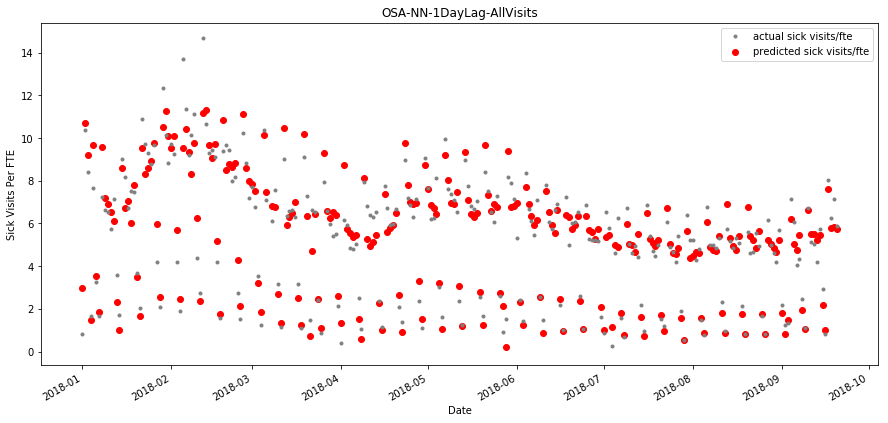

In [5]:
mse, _ = run_one_step_ahead_nn("OSA-NN-1DayLag-AllVisits", ONE_DAY_LAG_FEATURES,
                                ALL_VISITS_LABEL, epochs, patience, trials)

OSA-NN-7DayLag-AllVisits

Trial 1

....................................................................................................
....................................................................................................
.........14d ending with 2018-01-01 00:00:00 done; last one took 3.02 s
14d ending with 2018-01-15 00:00:00 done; last one took 0.16 s
14d ending with 2018-01-29 00:00:00 done; last one took 0.15 s
14d ending with 2018-02-12 00:00:00 done; last one took 0.15 s
14d ending with 2018-02-26 00:00:00 done; last one took 0.14 s
14d ending with 2018-03-13 00:00:00 done; last one took 0.13 s
14d ending with 2018-03-27 00:00:00 done; last one took 0.14 s
14d ending with 2018-04-10 00:00:00 done; last one took 0.11 s
14d ending with 2018-04-24 00:00:00 done; last one took 0.10 s
14d ending with 2018-05-08 00:00:00 done; last one took 0.10 s
14d ending with 2018-05-22 00:00:00 done; last one took 0.08 s
14d ending with 2018-06-05 00:00:00 done; last one took 0.09 

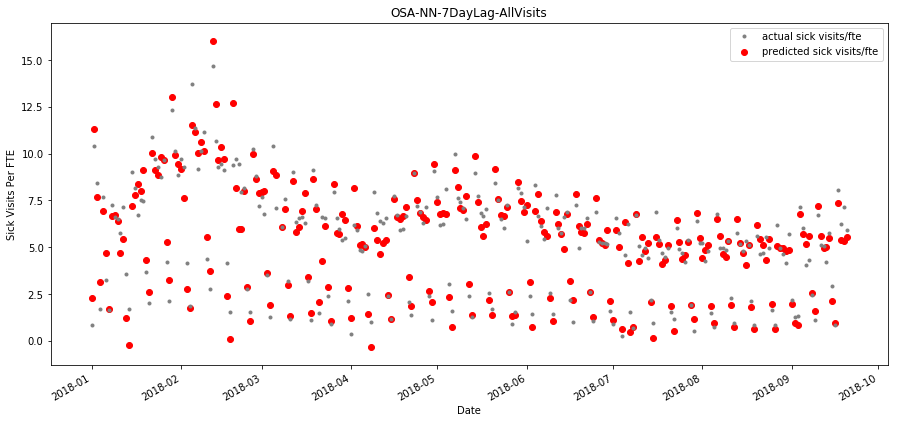

In [6]:
mse, _ = run_one_step_ahead_nn("OSA-NN-7DayLag-AllVisits", SEVEN_DAY_LAG_FEATURES,
                                ALL_VISITS_LABEL, epochs, patience, trials)

OSA-NN-7DayLag-Resp

Trial 1

....................................................................................................
...............................14d ending with 2018-01-01 00:00:00 done; last one took 4.31 s
14d ending with 2018-01-15 00:00:00 done; last one took 0.18 s
14d ending with 2018-01-29 00:00:00 done; last one took 0.19 s
14d ending with 2018-02-12 00:00:00 done; last one took 0.16 s
14d ending with 2018-02-26 00:00:00 done; last one took 0.15 s
14d ending with 2018-03-13 00:00:00 done; last one took 0.14 s
14d ending with 2018-03-27 00:00:00 done; last one took 0.13 s
14d ending with 2018-04-10 00:00:00 done; last one took 0.12 s
14d ending with 2018-04-24 00:00:00 done; last one took 0.11 s
14d ending with 2018-05-08 00:00:00 done; last one took 0.11 s
14d ending with 2018-05-22 00:00:00 done; last one took 0.09 s
14d ending with 2018-06-05 00:00:00 done; last one took 0.09 s
14d ending with 2018-06-19 00:00:00 done; last one took 0.07 s
14d ending with 201

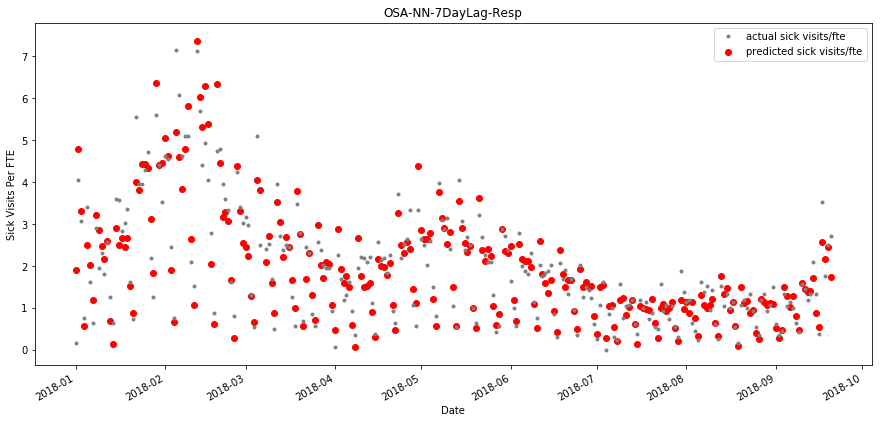

In [7]:
mses1, _ = run_one_step_ahead_nn("OSA-NN-7DayLag-Resp",
SEVEN_DAY_LAG_ICD8_FEATURES, ICD8_LABEL, epochs, patience, trials)

OSA-NN-7DayLag-NonResp

Trial 1

....................................................................................................
.................................14d ending with 2018-01-01 00:00:00 done; last one took 6.89 s
14d ending with 2018-01-15 00:00:00 done; last one took 0.20 s
14d ending with 2018-01-29 00:00:00 done; last one took 0.18 s
14d ending with 2018-02-12 00:00:00 done; last one took 0.17 s
14d ending with 2018-02-26 00:00:00 done; last one took 0.17 s
14d ending with 2018-03-13 00:00:00 done; last one took 0.16 s
14d ending with 2018-03-27 00:00:00 done; last one took 0.14 s
14d ending with 2018-04-10 00:00:00 done; last one took 0.13 s
14d ending with 2018-04-24 00:00:00 done; last one took 0.12 s
14d ending with 2018-05-08 00:00:00 done; last one took 0.11 s
14d ending with 2018-05-22 00:00:00 done; last one took 0.10 s
14d ending with 2018-06-05 00:00:00 done; last one took 0.09 s
14d ending with 2018-06-19 00:00:00 done; last one took 0.11 s
14d ending wit

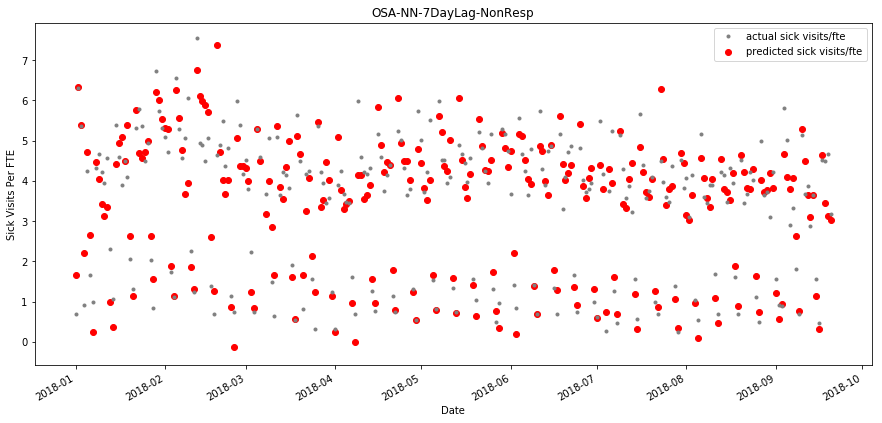

In [8]:
mses1, _ = run_one_step_ahead_nn("OSA-NN-7DayLag-NonResp",
SEVEN_DAY_LAG_ICD8OPP_FEATURES, ICD8OPP_LABEL, epochs, patience, trials)

OSA-NN-1DayLag-Resp

Trial 1

....................................................................................................
..........................................................................................14d ending with 2018-01-01 00:00:00 done; last one took 9.54 s
14d ending with 2018-01-15 00:00:00 done; last one took 0.25 s
14d ending with 2018-01-29 00:00:00 done; last one took 0.24 s
14d ending with 2018-02-12 00:00:00 done; last one took 0.21 s
14d ending with 2018-02-26 00:00:00 done; last one took 0.22 s
14d ending with 2018-03-13 00:00:00 done; last one took 0.18 s
14d ending with 2018-03-27 00:00:00 done; last one took 0.23 s
14d ending with 2018-04-10 00:00:00 done; last one took 0.16 s
14d ending with 2018-04-24 00:00:00 done; last one took 0.15 s
14d ending with 2018-05-08 00:00:00 done; last one took 0.18 s
14d ending with 2018-05-22 00:00:00 done; last one took 0.12 s
14d ending with 2018-06-05 00:00:00 done; last one took 0.11 s
14d ending with 2018-06

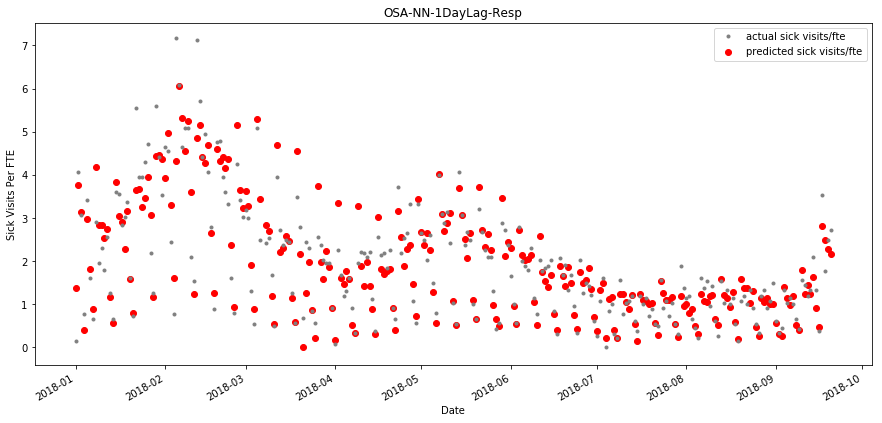

In [9]:
mses1, _ = run_one_step_ahead_nn("OSA-NN-1DayLag-Resp",
ONE_DAY_LAG_ICD8_FEATURES, ICD8_LABEL, epochs, patience, trials)

OSA-NN-1DayLag-NonResp

Trial 1

....................................................................................................
...............................................................................14d ending with 2018-01-01 00:00:00 done; last one took 10.91 s
14d ending with 2018-01-15 00:00:00 done; last one took 0.24 s
14d ending with 2018-01-29 00:00:00 done; last one took 0.27 s
14d ending with 2018-02-12 00:00:00 done; last one took 0.22 s
14d ending with 2018-02-26 00:00:00 done; last one took 0.21 s
14d ending with 2018-03-13 00:00:00 done; last one took 0.19 s
14d ending with 2018-03-27 00:00:00 done; last one took 0.19 s
14d ending with 2018-04-10 00:00:00 done; last one took 0.21 s
14d ending with 2018-04-24 00:00:00 done; last one took 0.16 s
14d ending with 2018-05-08 00:00:00 done; last one took 0.17 s
14d ending with 2018-05-22 00:00:00 done; last one took 0.13 s
14d ending with 2018-06-05 00:00:00 done; last one took 0.12 s
14d ending with 2018-06-19 00:

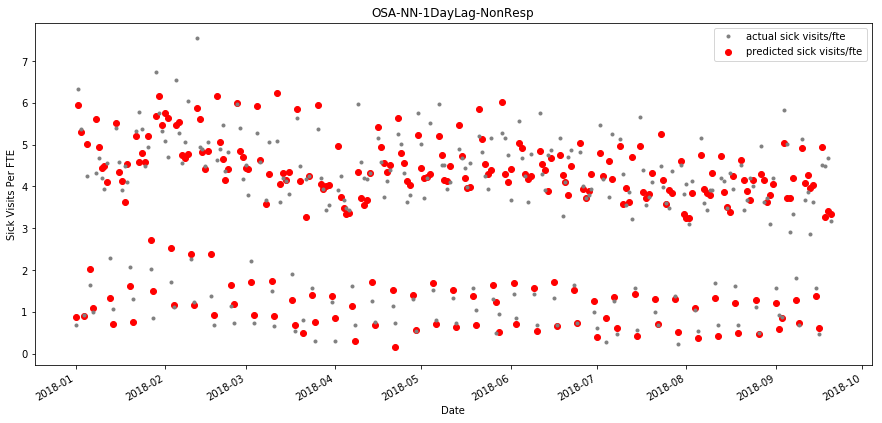

In [10]:
mses1, y_pred1 = run_one_step_ahead_nn("OSA-NN-1DayLag-NonResp",
ONE_DAY_LAG_ICD8OPP_FEATURES, ICD8OPP_LABEL, epochs, patience, trials)